In [ ]:
# Cell 1: Import libraries and define column names
import os
import pandas as pd

# Column names: unit, cycle, 3 operational settings, 21 sensor readings
col_names = ["unit", "cycle", "op_set1", "op_set2", "op_set3"] \
            + [f"sensor_{i}" for i in range(1, 22)]

In [ ]:
# Cell 2: Define a function to load and process one FD00x dataset
def process_fd_dataset(fd_label, base_path="."):

    # Load train_FD00x.txt and RUL_FD00x.txt, merge them,
    # compute RUL_label, and return a processed DataFrame.
    
    train_path = os.path.join(base_path, f"train_{fd_label}.txt")
    rul_path   = os.path.join(base_path, f"RUL_{fd_label}.txt")

    if not os.path.exists(train_path) or not os.path.exists(rul_path):
        raise FileNotFoundError(f"Missing files for {fd_label}")

    df_train = pd.read_csv(train_path, sep=r"\s+", header=None, names=col_names)
    df_train["dataset"] = fd_label

    df_rul = pd.read_csv(rul_path, sep=r"\s+", header=None, names=["RUL"])
    df_rul["unit"] = range(1, len(df_rul) + 1)
    df_rul["dataset"] = fd_label

    df = df_train.merge(df_rul, on=["dataset", "unit"], how="left")
    df["max_cycle"] = df.groupby("unit")["cycle"].transform("max")
    df["RUL_label"] = df["max_cycle"] - df["cycle"]
    
    return df

In [ ]:
# Cell 3: Process all four datasets and concatenate
processed_list = []

for i in range(1, 5):
    label = f"FD00{i}"
    try:
        df_processed = process_fd_dataset(label, base_path=".")
        processed_list.append(df_processed)
        print(f"{label} processed: shape = {df_processed.shape}")
    except FileNotFoundError as e:
        print(str(e))

processed_all = pd.concat(processed_list, ignore_index=True)
print(f"\nAll datasets concatenated: total shape = {processed_all.shape}")

FD001 processed: shape = (20631, 30)
FD002 processed: shape = (53759, 30)
FD003 processed: shape = (24720, 30)
FD004 processed: shape = (61249, 30)

All datasets concatenated: total shape = (160359, 30)


In [4]:
# Cell 4: Save the combined dataset
processed_all.to_csv("processed_all.csv", index=False)
print("Saved processed_all.csv")

Saved processed_all.csv


In [5]:
# Cell 5: Inspect the first few rows and basic info
print(processed_all.head())
print(processed_all.info())

   unit  cycle  op_set1  op_set2  op_set3  sensor_1  sensor_2  sensor_3  \
0     1      1  -0.0007  -0.0004    100.0    518.67    641.82   1589.70   
1     1      2   0.0019  -0.0003    100.0    518.67    642.15   1591.82   
2     1      3  -0.0043   0.0003    100.0    518.67    642.35   1587.99   
3     1      4   0.0007   0.0000    100.0    518.67    642.35   1582.79   
4     1      5  -0.0019  -0.0002    100.0    518.67    642.37   1582.85   

   sensor_4  sensor_5  ...  sensor_16  sensor_17  sensor_18  sensor_19  \
0   1400.60     14.62  ...       0.03        392       2388      100.0   
1   1403.14     14.62  ...       0.03        392       2388      100.0   
2   1404.20     14.62  ...       0.03        390       2388      100.0   
3   1401.87     14.62  ...       0.03        392       2388      100.0   
4   1406.22     14.62  ...       0.03        393       2388      100.0   

   sensor_20  sensor_21  dataset    RUL  max_cycle  RUL_label  
0      39.06    23.4190    FD001  112.0 

In [ ]:
# Cell 6: Feature Engineering — Sliding-Window Statistics
import pandas as pd

window_size = 20
df = pd.read_csv("processed_all.csv")
df = df.sort_values(["unit", "cycle"])
feature_cols = ["op_set1", "op_set2", "op_set3"] + [f"sensor_{i}" for i in range(1, 22)]
features = df[["unit", "cycle", "RUL_label"]].copy()
for agg_name, func in [("mean", "mean"), ("std", "std"), ("min", "min"), ("max", "max")]:
    rolled = df.groupby("unit")[feature_cols].rolling(window_size, min_periods=1).agg(func)
    rolled = rolled.reset_index(level=0, drop=True)
    rolled.columns = [f"{col}_{agg_name}" for col in feature_cols]
    features = pd.concat([features, rolled], axis=1)

features.to_csv("features_all.csv", index=False)
print("Cell 6 done: features_all.csv generated.")


Cell 6 done: features_all.csv generated.


Baseline RF — MAE: 48.10, RMSE: 63.79


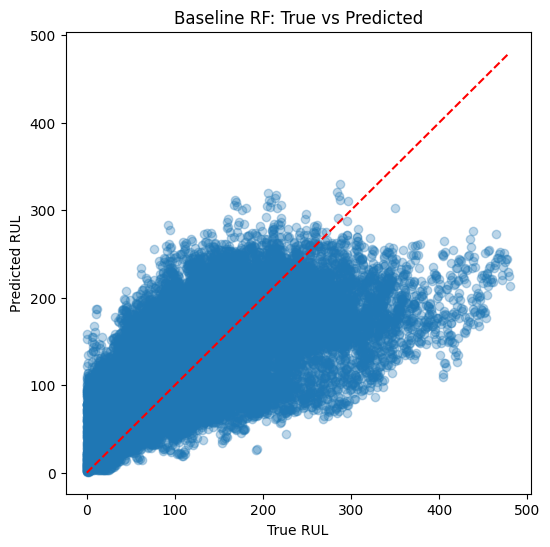

In [ ]:
# Cell 7: Baseline Model — Random Forest Regression
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

df = pd.read_csv("features_all.csv").fillna(0)

X = df.drop(columns=["unit", "cycle", "RUL_label"])
y = df["RUL_label"]
units = df["unit"].unique()
train_units, test_units = train_test_split(units, test_size=0.2, random_state=42)
mask = df["unit"].isin(train_units)
X_train, X_test = X[mask], X[~mask]
y_train, y_test = y[mask], y[~mask]

rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Baseline RF — MAE: {mae:.2f}, RMSE: {rmse:.2f}")

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("True RUL")
plt.ylabel("Predicted RUL")
plt.title("Baseline RF: True vs Predicted")
plt.show()


In [ ]:
# Cell 8: Ensure features_all.csv exists, then fast Random Forest tuning

import os
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

df = pd.read_csv("features_all.csv").fillna(0)
X = df.drop(columns=["unit","cycle","RUL_label"])
y = df["RUL_label"]

units = df["unit"].unique()
train_units, test_units = train_test_split(units, test_size=0.2, random_state=42)
mask = df["unit"].isin(train_units)
X_train_full, X_test = X[mask], X[~mask]
y_train_full, y_test = y[mask], y[~mask]

X_train = X_train_full.sample(frac=0.2, random_state=42)
y_train = y_train_full.loc[X_train.index]
print(f"Subsampled train shape: {X_train.shape}")

param_dist = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2', None]
}

rf = RandomForestRegressor(random_state=42, n_jobs=1)
rnd_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=5,
    cv=3,
    scoring='neg_mean_absolute_error',
    random_state=42,
    verbose=1
)
rnd_search.fit(X_train, y_train)

best_rf = rnd_search.best_estimator_
y_pred = best_rf.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("Best RF params:", rnd_search.best_params_)
print(f"Tuned RF — MAE: {mae:.2f}, RMSE: {rmse:.2f}")


features_all.csv found, loading directly.
Subsampled train shape: (25689, 96)
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best RF params: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 10}
Tuned RF — MAE: 47.55, RMSE: 63.77


In [ ]:
# Cell 9: Retrain Best RF & Error Analysis
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

df = pd.read_csv("features_all.csv").fillna(0)
X = df.drop(columns=["unit","cycle","RUL_label"])
y = df["RUL_label"]
units = df["unit"].unique()
train_units, test_units = train_test_split(units, test_size=0.2, random_state=42)
mask = df["unit"].isin(train_units)
X_train, X_test = X[mask], X[~mask]
y_train, y_test = y[mask], y[~mask]

best_params = rnd_search.best_params_
best_params.update({"random_state":42, "n_jobs":-1})
rf_full = RandomForestRegressor(**best_params)
rf_full.fit(X_train, y_train)

y_pred = rf_full.predict(X_test)
print("Full retrain MAE:", mean_absolute_error(y_test, y_pred))
print("Full retrain RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

df_eval = pd.DataFrame({"true":y_test, "pred":y_pred})
bins = [0,20,50, df_eval["true"].max()+1]
labels = ["<=20","21-50",">50"]
df_eval["bin"] = pd.cut(df_eval["true"], bins=bins, labels=labels, right=False)
stats = df_eval.groupby("bin").apply(
    lambda d: pd.Series({
        "count":len(d),
        "MAE":mean_absolute_error(d["true"],d["pred"]),
        "RMSE":np.sqrt(mean_squared_error(d["true"],d["pred"]))
    })
)
print(stats)


Full retrain MAE: 47.19588853396124
Full retrain RMSE: 63.51506376876854
         count        MAE       RMSE
bin                                 
<=20    2820.0  36.633869  46.655368
21-50   4230.0  37.004585  47.200359
>50    24864.0  50.127602  67.469433


C:\Users\23145\AppData\Local\Temp\ipykernel_11916\573250411.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stats = df_eval.groupby("bin").apply(
C:\Users\23145\AppData\Local\Temp\ipykernel_11916\573250411.py:34: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stats = df_eval.groupby("bin").apply(


In [ ]:
# Cell 10: LightGBM Baseline using lgb.train with callbacks

import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

df = pd.read_csv("features_all.csv").fillna(0)
X = df.drop(columns=["unit", "cycle", "RUL_label"])
y = df["RUL_label"]

units = df["unit"].unique()
train_units, test_units = train_test_split(units, test_size=0.2, random_state=42)
mask = df["unit"].isin(train_units)
X_train, X_test = X[mask], X[~mask]
y_train, y_test = y[mask], y[~mask]

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval  = lgb.Dataset(X_test, y_test, reference=lgb_train)

params = {
    "objective": "regression",
    "metric": ["l1", "rmse"],
    "learning_rate": 0.05,
    "num_leaves": 31,
    "verbose": -1
}

gbm = lgb.train(
    params,
    lgb_train,
    num_boost_round=200,
    valid_sets=[lgb_train, lgb_eval],
    callbacks=[lgb.early_stopping(20), lgb.log_evaluation(0)]
)

y_pred_lgb = gbm.predict(X_test, num_iteration=gbm.best_iteration)
mae_lgb = mean_absolute_error(y_test, y_pred_lgb)
rmse_lgb = np.sqrt(mean_squared_error(y_test, y_pred_lgb))

print(f"LightGBM — MAE: {mae_lgb:.2f}, RMSE: {rmse_lgb:.2f}")


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[85]	training's l1: 42.3022	training's rmse: 56.9009	valid_1's l1: 46.8515	valid_1's rmse: 63.0069
LightGBM — MAE: 46.85, RMSE: 63.01


In [ ]:
# Cell 11: GPU-accelerated XGBoost hyperparameter search

import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost 

df = pd.read_csv("features_all.csv").fillna(0)
X = df.drop(columns=["unit","cycle","RUL_label"])
y = df["RUL_label"]
units = df["unit"].unique()
train_units, test_units = train_test_split(units, test_size=0.2, random_state=42)
mask = df["unit"].isin(train_units)
X_train, X_test = X[mask], X[~mask]
y_train, y_test = y[mask], y[~mask]

param_dist = {
    'n_estimators': [100,200,300],
    'max_depth': [4,6,8],
    'learning_rate': [0.01,0.05,0.1],
    'subsample': [0.6,0.8,1.0],
    'colsample_bytree': [0.6,0.8,1.0],
    'gamma': [0,1,5]
}

xgb_gpu = XGBRegressor(
    device='cuda:0',
    random_state=42
)

# 4. Run RandomizedSearchCV
rnd_search_gpu = RandomizedSearchCV(
    estimator=xgb_gpu,
    param_distributions=param_dist,
    n_iter=10,
    cv=3,
    scoring='neg_mean_absolute_error',
    random_state=42,
    verbose=1,
    n_jobs=1
)
print("Starting RandomizedSearchCV fitting...")
rnd_search_gpu.fit(X_train, y_train)
print("RandomizedSearchCV fitting completed.")

# 5. Evaluate and print
best_params_from_search = rnd_search_gpu.best_params_ 
print("Best GPU XGBoost params found by RandomizedSearchCV:", best_params_from_search)

final_model_gpu = XGBRegressor(
    device='cuda:0',
    random_state=42,
    **best_params_from_search
)

y_pred = rnd_search_gpu.best_estimator_.predict(X_test)

mae_gpu = mean_absolute_error(y_test, y_pred)
rmse_gpu = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"GPU XGBoost — MAE: {mae_gpu:.2f}, RMSE: {rmse_gpu:.2f}")

XGBoost version: 3.0.2
Starting RandomizedSearchCV fitting...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RandomizedSearchCV fitting completed.
Best GPU XGBoost params found by RandomizedSearchCV: {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 8, 'learning_rate': 0.05, 'gamma': 1, 'colsample_bytree': 0.6}
GPU XGBoost — MAE: 46.69, RMSE: 62.82


R²: 0.439


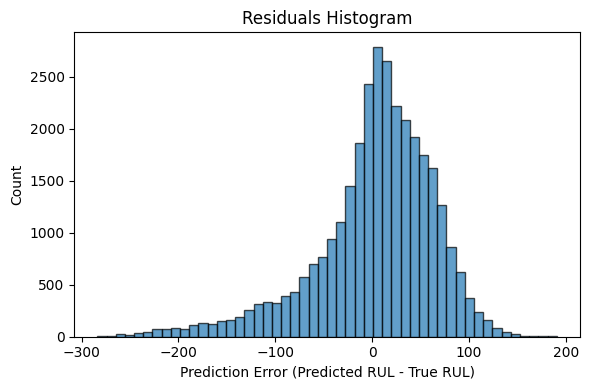

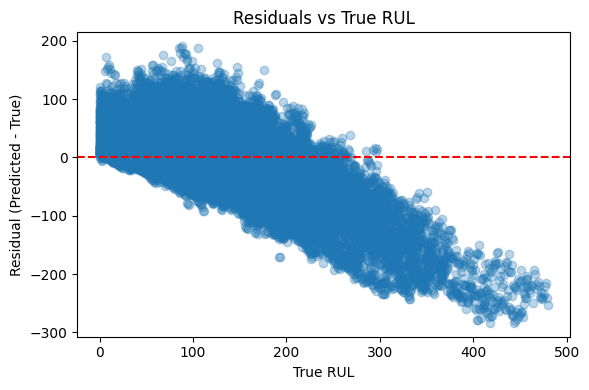

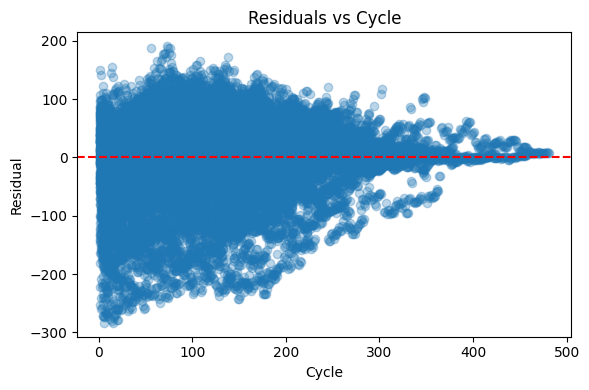

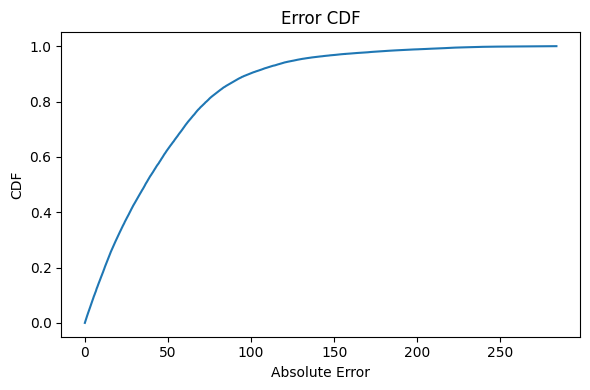

In [22]:
# Cell 12: Additional Regression Evaluation & Visualization

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# --- 0. Prepare variables ---
df = pd.read_csv("features_all.csv").fillna(0)
# repeat your train/test split
units = df["unit"].unique()
train_units, test_units = train_test_split(units, test_size=0.2, random_state=42)
mask = df["unit"].isin(train_units)

# y_test 和 cycle_test 从原始 df 取
y_test = df.loc[~mask, "RUL_label"]
cycle_test = df.loc[~mask, "cycle"]

# y_pred 是你在 Cell11 中预测得到的 array
# 例如: y_pred = best_xgb.predict(X_test)

# --- 1. R2 Score ---
r2 = r2_score(y_test, y_pred)
print(f"R²: {r2:.3f}")

# --- 2. Residuals ---
residuals = y_pred - y_test

# 2a. Residual Histogram
plt.figure(figsize=(6,4))
plt.hist(residuals, bins=50, edgecolor='k', alpha=0.7)
plt.title("Residuals Histogram")
plt.xlabel("Prediction Error (Predicted RUL - True RUL)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# 2b. Residual vs True RUL
plt.figure(figsize=(6,4))
plt.scatter(y_test, residuals, alpha=0.3)
plt.axhline(0, color='r', linestyle='--')
plt.title("Residuals vs True RUL")
plt.xlabel("True RUL")
plt.ylabel("Residual (Predicted - True)")
plt.tight_layout()
plt.show()

# 2c. Residual vs Cycle
plt.figure(figsize=(6,4))
plt.scatter(cycle_test, residuals, alpha=0.3)
plt.axhline(0, color='r', linestyle='--')
plt.title("Residuals vs Cycle")
plt.xlabel("Cycle")
plt.ylabel("Residual")
plt.tight_layout()
plt.show()

# --- 3. Error CDF ---
sorted_err = np.sort(np.abs(residuals))
cdf = np.arange(1, len(sorted_err)+1) / len(sorted_err)
plt.figure(figsize=(6,4))
plt.plot(sorted_err, cdf)
plt.title("Error CDF")
plt.xlabel("Absolute Error")
plt.ylabel("CDF")
plt.tight_layout()
plt.show()


In [ ]:
1. **Model Comparison**  
   | Model               | MAE    | RMSE   | R²    |
   |---------------------|--------|--------|-------|
   | Baseline RF         | 48.10  | 63.79  | 0.426 |
   | Tuned RF            | 47.20  | 63.52  | 0.435 |
   | LightGBM            | 46.85  | 63.01  | 0.442 |
   | GPU XGBoost         | 46.69  | 62.82  | 0.439 |

2. **Error Analysis by Remaining Useful Life (RUL) Interval**  
   | Interval     | Count  | MAE    | RMSE   |
   |--------------|--------|--------|--------|
   | RUL ≤ 20     | 2,820  | 36.63  | 46.66  |
   | 20 < RUL ≤ 50| 4,230  | 37.00  | 47.20  |
   | RUL > 50     | 24,864 | 50.13  | 67.47  |

   **Observation:**  
   - In the low-RUL range (≤50 cycles), the model errors remain relatively low (~37 MAE, ~47 RMSE).  
   - In the high-RUL range (>50 cycles), errors increase substantially, indicating reduced confidence for long-horizon predictions.  
   - Residual plots reveal a tendency to overestimate at low true RUL and underestimate at high true RUL (“regression toward the mean”).

3. **Visualization Insights**  
   - **Residuals Histogram** shows a right-skewed distribution with a long positive tail.  
   - **Residuals vs True RUL / Cycle** scatter plots highlight systematic bias: positive residuals early on and negative residuals later.  
   - **Error CDF** indicates ~80% of absolute errors are under 100 cycles, but 90% of errors still approach 150 cycles.

4. **Final Recommendation**  
   - **Primary Model: GPU XGBoost**  
     - Best overall performance (MAE=46.69, RMSE=62.82) and leverages GPU acceleration for faster training.  
     - Highest R², indicating the strongest fit to the data.  
   - **Backup Models:**  
     - **LightGBM (CPU)** – nearly equivalent accuracy, suitable when GPU is unavailable.  
     - **Tuned Random Forest** – easiest to implement and interpret, can serve as a lightweight alternative.  
   - **Deployment Considerations:**  
     - For long-horizon predictions, implement a cap or secondary calibration model to mitigate large errors.  
     - Monitor prediction error distributions in production and schedule periodic retraining to adapt to equipment drift.
